In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
pd.set_option('max_columns',100)
pd.set_option('max_row',10000000000)
from fbprophet import Prophet

In [2]:
#import dataset
orders_df = pd.read_csv('data/olist_orders_dataset.csv')
order_items_df = pd.read_csv('data/olist_order_items_dataset.csv')
products_df = pd.read_csv('data/olist_products_dataset.csv')

In [3]:
#checking out columns
orders_df.columns, order_items_df.columns, products_df.columns

(Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
        'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date'],
       dtype='object'),
 Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
        'shipping_limit_date', 'price', 'freight_value'],
       dtype='object'),
 Index(['product_id', 'product_category_name', 'product_name_lenght',
        'product_description_lenght', 'product_photos_qty', 'product_weight_g',
        'product_length_cm', 'product_height_cm', 'product_width_cm'],
       dtype='object'))

In [4]:
#change necessary columns to datetime
for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    orders_df[col] = pd.to_datetime(orders_df[col])

In [5]:
#merge three different dataframe that has columns we need
customers_order_items_df = pd.merge(orders_df, order_items_df, on='order_id', how='left')
customers_order_items_df = pd.merge(customers_order_items_df, products_df, on='product_id', how='left')
customers_order_items_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,automotivo,46.0,232.0,1.0,420.0,24.0,19.0,21.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,pet_shop,59.0,468.0,3.0,450.0,30.0,10.0,20.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,papelaria,38.0,316.0,4.0,250.0,51.0,15.0,15.0


In [6]:
customers_order_items_df['order_status'].value_counts()

delivered      110197
shipped          1186
canceled          706
unavailable       610
invoiced          361
processing        357
created             5
approved            3
Name: order_status, dtype: int64

In [7]:
#drop columns that contain invalid orders(cancelled,unavailable)
index_to_drop = customers_order_items_df[(customers_order_items_df['order_status']=='canceled')|(customers_order_items_df['order_status']=='unavailable')].index

customers_order_items_df.drop(index_to_drop,inplace=True)

In [8]:
#checking the most popular products
customers_order_items_df['product_category_name'].value_counts()

cama_mesa_banho                                   11097
beleza_saude                                       9634
esporte_lazer                                      8590
moveis_decoracao                                   8298
informatica_acessorios                             7781
utilidades_domesticas                              6915
relogios_presentes                                 5970
telefonia                                          4527
ferramentas_jardim                                 4328
automotivo                                         4204
brinquedos                                         4083
cool_stuff                                         3779
perfumaria                                         3402
bebes                                              3043
eletronicos                                        2755
papelaria                                          2505
fashion_bolsas_e_acessorios                        2025
pet_shop                                        

In [9]:
#selecting the most popular product which is cama_mesa_banho(bed_bath_table)
customers_order_items_df = customers_order_items_df.groupby('product_category_name',as_index=False)
df = customers_order_items_df.get_group('cama_mesa_banho')
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
14,5ff96c15d0b717ac6ad1f3d77225a350,19402a48fe860416adf93348aba37740,delivered,2018-07-25 17:44:10,2018-07-25 17:55:14,2018-07-26 13:16:00,2018-07-30 15:52:25,2018-08-08,1.0,10adb53d8faa890ca7c2f0cbcb68d777,1900267e848ceeba8fa32d80c1a5f5a8,2018-07-27 17:55:14,19.90,12.80,cama_mesa_banho,52.0,155.0,1.0,200.0,16.0,10.0,16.0
19,85ce859fd6dc634de8d2f1e290444043,059f7fc5719c7da6cbafe370971a8d70,delivered,2017-11-21 00:03:41,2017-11-21 00:14:22,2017-11-23 21:32:26,2017-11-27 18:28:00,2017-12-11,1.0,cce679660c66e6fbd5c8091dfd29e9cd,d2374cbcbb3ca4ab1086534108cc3ab7,2017-11-29 00:14:22,17.90,11.85,cama_mesa_banho,43.0,125.0,1.0,250.0,40.0,4.0,30.0
41,7206b86ea789983f7a273ea7fa0bc2a8,3391c4bc11a817e7973e498b0b023158,delivered,2018-03-26 17:12:18,2018-03-26 17:28:27,2018-03-28 17:22:53,2018-04-05 22:11:18,2018-04-12,1.0,9a469eaf45dfbc43d39ba1977a3c07af,d2374cbcbb3ca4ab1086534108cc3ab7,2018-03-30 17:27:57,36.90,12.79,cama_mesa_banho,44.0,192.0,1.0,700.0,40.0,4.0,30.0
64,68873cf91053cd11e6b49a766db5af1a,4632eb5a8f175f6fe020520ae0c678f3,delivered,2017-11-30 22:02:15,2017-12-02 02:51:18,2017-12-04 22:07:01,2017-12-05 20:28:40,2017-12-18,1.0,15a9e834e89eab39d973492882c658d6,a673821011d0cec28146ea42f5ab767f,2017-12-07 02:51:18,79.90,11.76,cama_mesa_banho,52.0,530.0,6.0,949.0,30.0,20.0,26.0
97,10c320f977c6a18f91b2d14be13128c6,b673f0597cb0c4d12778f731045f361a,delivered,2017-05-09 20:48:59,2017-05-09 21:02:45,2017-05-10 11:22:15,2017-05-18 13:22:35,2017-06-01,1.0,b3be1f83cef05668c25e134852d44545,3b15288545f8928d3e65a8f949a28291,2017-05-16 21:02:45,110.99,21.27,cama_mesa_banho,52.0,413.0,1.0,1750.0,42.0,11.0,36.0


In [10]:
df.set_index('order_purchase_timestamp',inplace=True)

In [11]:
df = df[['price']]

In [12]:
#resampling the dataframe to daily contain daily samples
daily_df = df.resample('D').sum()
daily_df.reset_index(inplace=True)

In [13]:
daily_df.head()

,order_purchase_timestamp,price
0,2016-10-04,159.8
1,2016-10-05,169.9
2,2016-10-06,59.9
3,2016-10-07,0.0
4,2016-10-08,0.0


In [14]:
#rename columns
daily_df.columns = ['ds','y']

In [15]:
daily_df

,ds,y
0,2016-10-04,159.80
1,2016-10-05,169.90
2,2016-10-06,59.90
3,2016-10-07,0.00
4,2016-10-08,0.00
5,2016-10-09,89.39
6,2016-10-10,0.00
7,2016-10-11,0.00
8,2016-10-12,0.00
9,2016-10-13,0.00


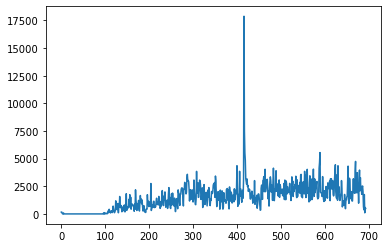

In [16]:
daily_df.y.plot();

In [17]:
#a lot of the first few days contained 0 which I think is are outliers or data for those days weren't recorded
daily_df = daily_df[96:]

In [18]:
daily_df.tail()

,ds,y
689,2018-08-24,371.68
690,2018-08-25,1753.03
691,2018-08-26,98.78
692,2018-08-27,580.50
693,2018-08-28,485.79


In [19]:
# fitting model
model = Prophet(yearly_seasonality=True)
model.fit(daily_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
#predicting values
future = model.make_future_dataframe(periods= 365,freq= 'D')
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-08,282.833765,-1158.307635,1249.861372,282.833765,282.833765,-185.769340,-185.769340,-185.769340,-178.842551,-178.842551,-178.842551,-6.926790,-6.926790,-6.926790,0.0,0.0,0.0,97.064424
1,2017-01-09,289.160645,-788.998710,1686.050575,289.160645,289.160645,137.575096,137.575096,137.575096,99.688574,99.688574,99.688574,37.886522,37.886522,37.886522,0.0,0.0,0.0,426.735741
2,2017-01-10,295.487526,-526.248502,1799.090152,295.487526,295.487526,325.552339,325.552339,325.552339,253.641191,253.641191,253.641191,71.911148,71.911148,71.911148,0.0,0.0,0.0,621.039865
3,2017-01-11,301.814406,-712.262525,1686.764542,301.814406,301.814406,266.987258,266.987258,266.987258,171.614509,171.614509,171.614509,95.372750,95.372750,95.372750,0.0,0.0,0.0,568.801665
4,2017-01-12,308.141287,-817.144832,1779.901328,308.141287,308.141287,160.258100,160.258100,160.258100,51.495926,51.495926,51.495926,108.762174,108.762174,108.762174,0.0,0.0,0.0,468.399387
5,2017-01-13,314.468168,-831.027665,1401.441696,314.468168,314.468168,16.035644,16.035644,16.035644,-96.773569,-96.773569,-96.773569,112.809213,112.809213,112.809213,0.0,0.0,0.0,330.503812
6,2017-01-14,320.795048,-1033.371628,1337.203922,320.795048,320.795048,-192.373143,-192.373143,-192.373143,-300.824079,-300.824079,-300.824079,108.450936,108.450936,108.450936,0.0,0.0,0.0,128.421905
7,2017-01-15,327.121929,-813.275961,1466.450022,327.121929,327.121929,-82.046928,-82.046928,-82.046928,-178.842551,-178.842551,-178.842551,96.795623,96.795623,96.795623,0.0,0.0,0.0,245.075001
8,2017-01-16,333.448809,-679.926603,1716.530608,333.448809,333.448809,178.771963,178.771963,178.771963,99.688574,99.688574,99.688574,79.083389,79.083389,79.083389,0.0,0.0,0.0,512.220772
9,2017-01-17,339.775690,-563.841822,1860.968450,339.775690,339.775690,310.285878,310.285878,310.285878,253.641191,253.641191,253.641191,56.644687,56.644687,56.644687,0.0,0.0,0.0,650.061567


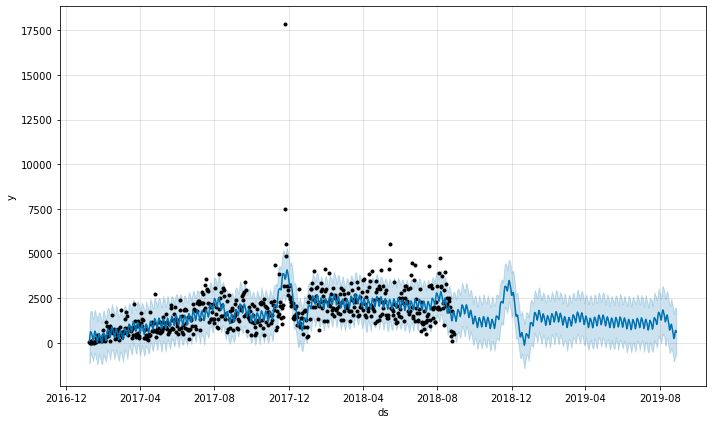

In [21]:
model.plot(forecast);

In [22]:
predicted_values = forecast[694:]
predicted_values = predicted_values[['ds','yhat']]
predicted_values.columns = ['date','revenue']

In [23]:
predicted_values

,date,revenue
694,2018-12-03,2808.906567
695,2018-12-04,2810.961320
696,2018-12-05,2563.692598
697,2018-12-06,2267.605925
698,2018-12-07,1935.463763
699,2018-12-08,1542.601665
700,2018-12-09,1473.880084
701,2018-12-10,1562.881492
702,2018-12-11,1531.495740
703,2018-12-12,1271.229883


In [24]:
import matplotlib.pyplot as plt

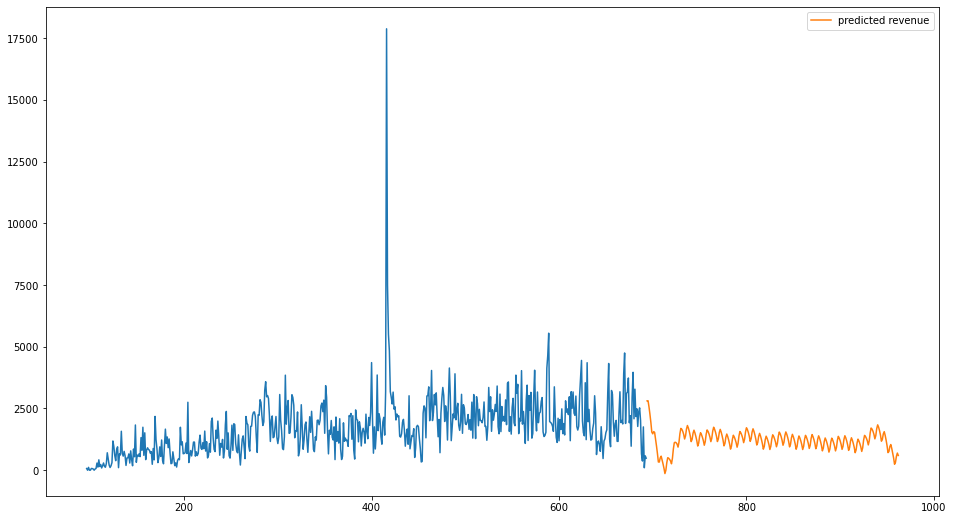

In [25]:
plt.rcParams["figure.figsize"] = (16,9)
fig, ax = plt.subplots()
ax.plot(daily_df.y)
ax.plot(predicted_values.revenue, label='predicted revenue')
leg = ax.legend(loc ="upper right");

The coming days seems to be rough for bed_table_bath products we might want to reduce money budgeted for advertising this product.